In [1]:
import skimage.transform as st
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

In [2]:
class Hough(object):
    def __init__(self, cam_num, grid_len, diag_len, start_time=0, freq=25):
        self.cam_num = cam_num
        self.grid_len = grid_len
        self.diag_len = diag_len
        self.start_time = start_time
        self.freq = freq
        
        self.accumulators = []
        for i in range(cam_num):
            accumulator_row = []
            for j in range(i+1):
                accumulator_row.append(np.zeros((diag_len, diag_len)))
            self.accumulators.append(accumulator_row)
            
        self.deltas = []
        for i in range(cam_num):
            delta_row = []
            for j in range(i+1):
                delta_row.append([])
            self.deltas.append(delta_row)
            
    def update(self, c1, c2, t1, t2, val=1):
        c1r, c2r = (c1, c2) if c1 > c2 else (c2, c1)
        t1r, t2r = ((t1 - self.start_time) / self.freq, (t2 - self.start_time) / self.freq)
        t1r, t2r = (t1r, t2r) if c1 > c2 else (t2r, t1r)
        accumulator = self.accumulators[c1r][c2r]
        accumulator[int(t1r / self.grid_len)][int(t2r / self.grid_len)] += val
        self.deltas[c1r][c2r].append(t1r - t2r)

In [12]:
hough = Hough(8, 40, 230, 2935)

In [13]:
with open('data/duke.list', 'r') as f:
    lines = f.readlines()
    l = len(lines)
    for i in tqdm(range(l)):
        for j in range(i + 1, l):
            line1, line2 = lines[i], lines[j]
            p1, c1, _, t1 = map(int, line1.strip('.jpg\n').split('_'))
            p2, c2, _, t2 = map(int, line2.strip('.jpg\n').split('_'))
            if p1 != p2: break
            hough.update(c1, c2, t1, t2)

100%|██████████| 36411/36411 [00:12<00:00, 3013.84it/s]


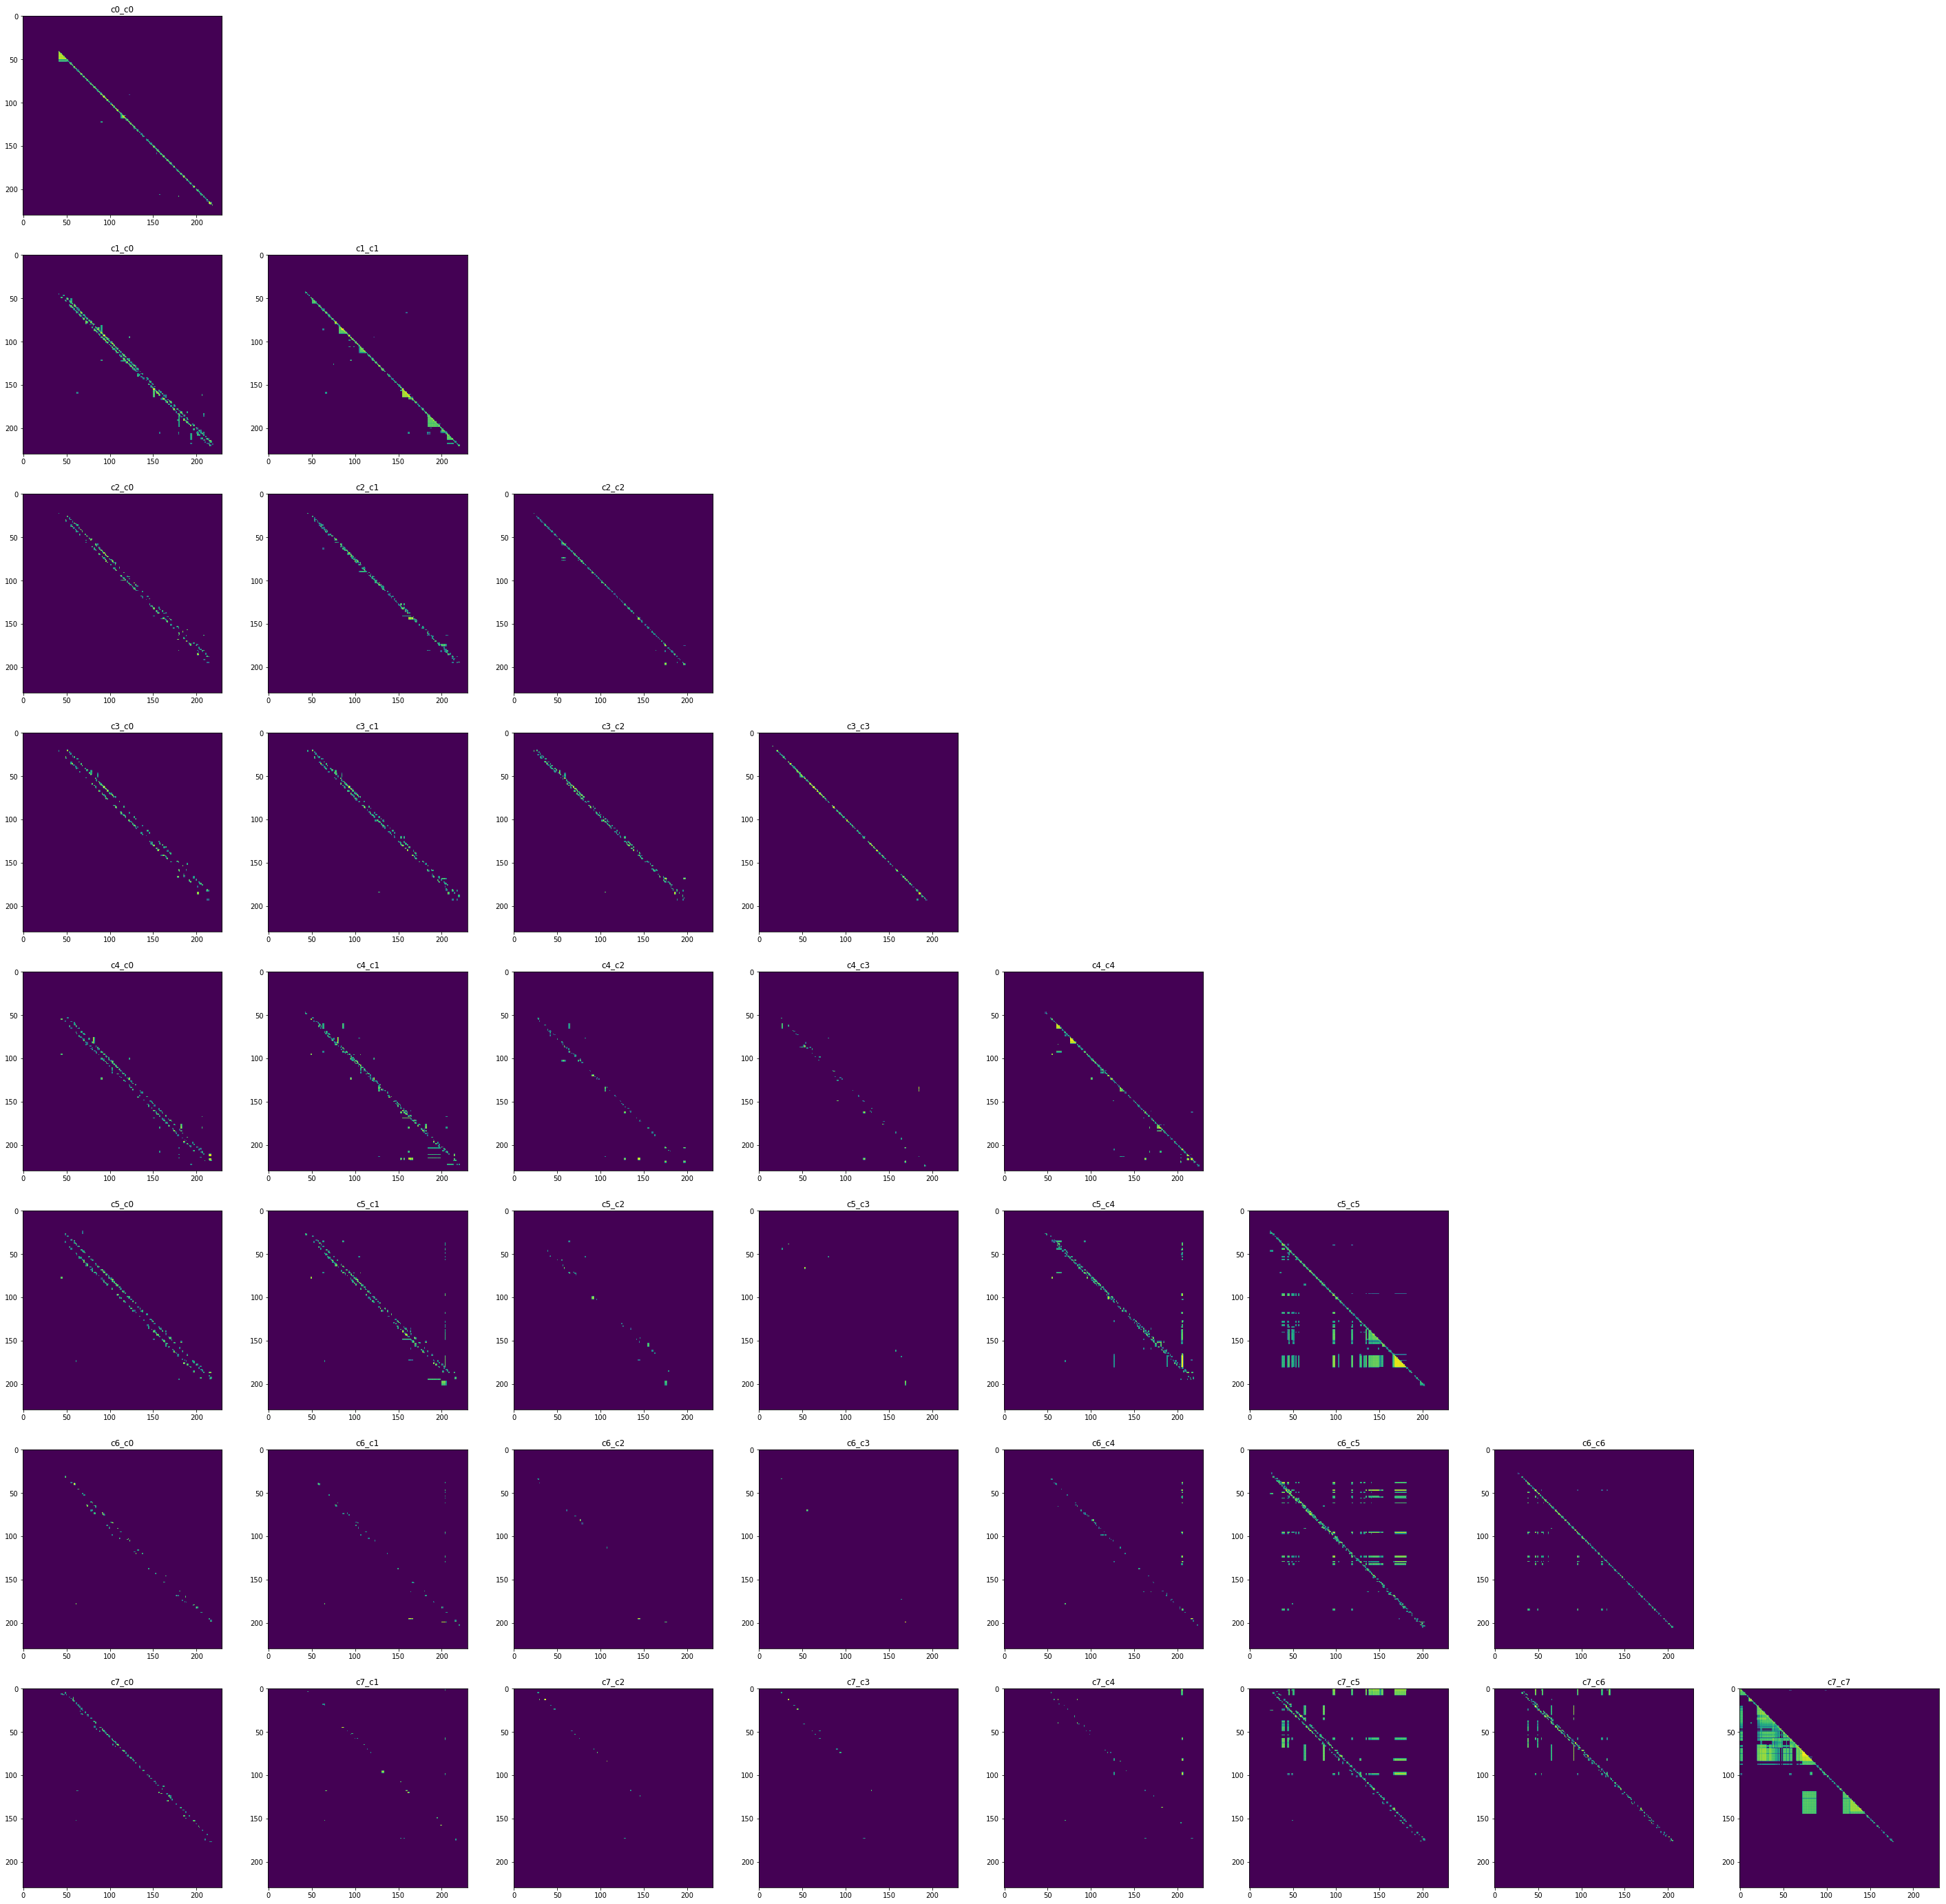

In [16]:
cam_num = 8
plt.figure(figsize=(50,50))
for i in range(cam_num):
    for j in range(i+1):
        plt.subplot(cam_num, cam_num, i * cam_num + j + 1)
        plt.imshow(np.log(hough.accumulators[i][j] + 1))
        plt.title('c%d_c%d' % (i, j))
plt.show()

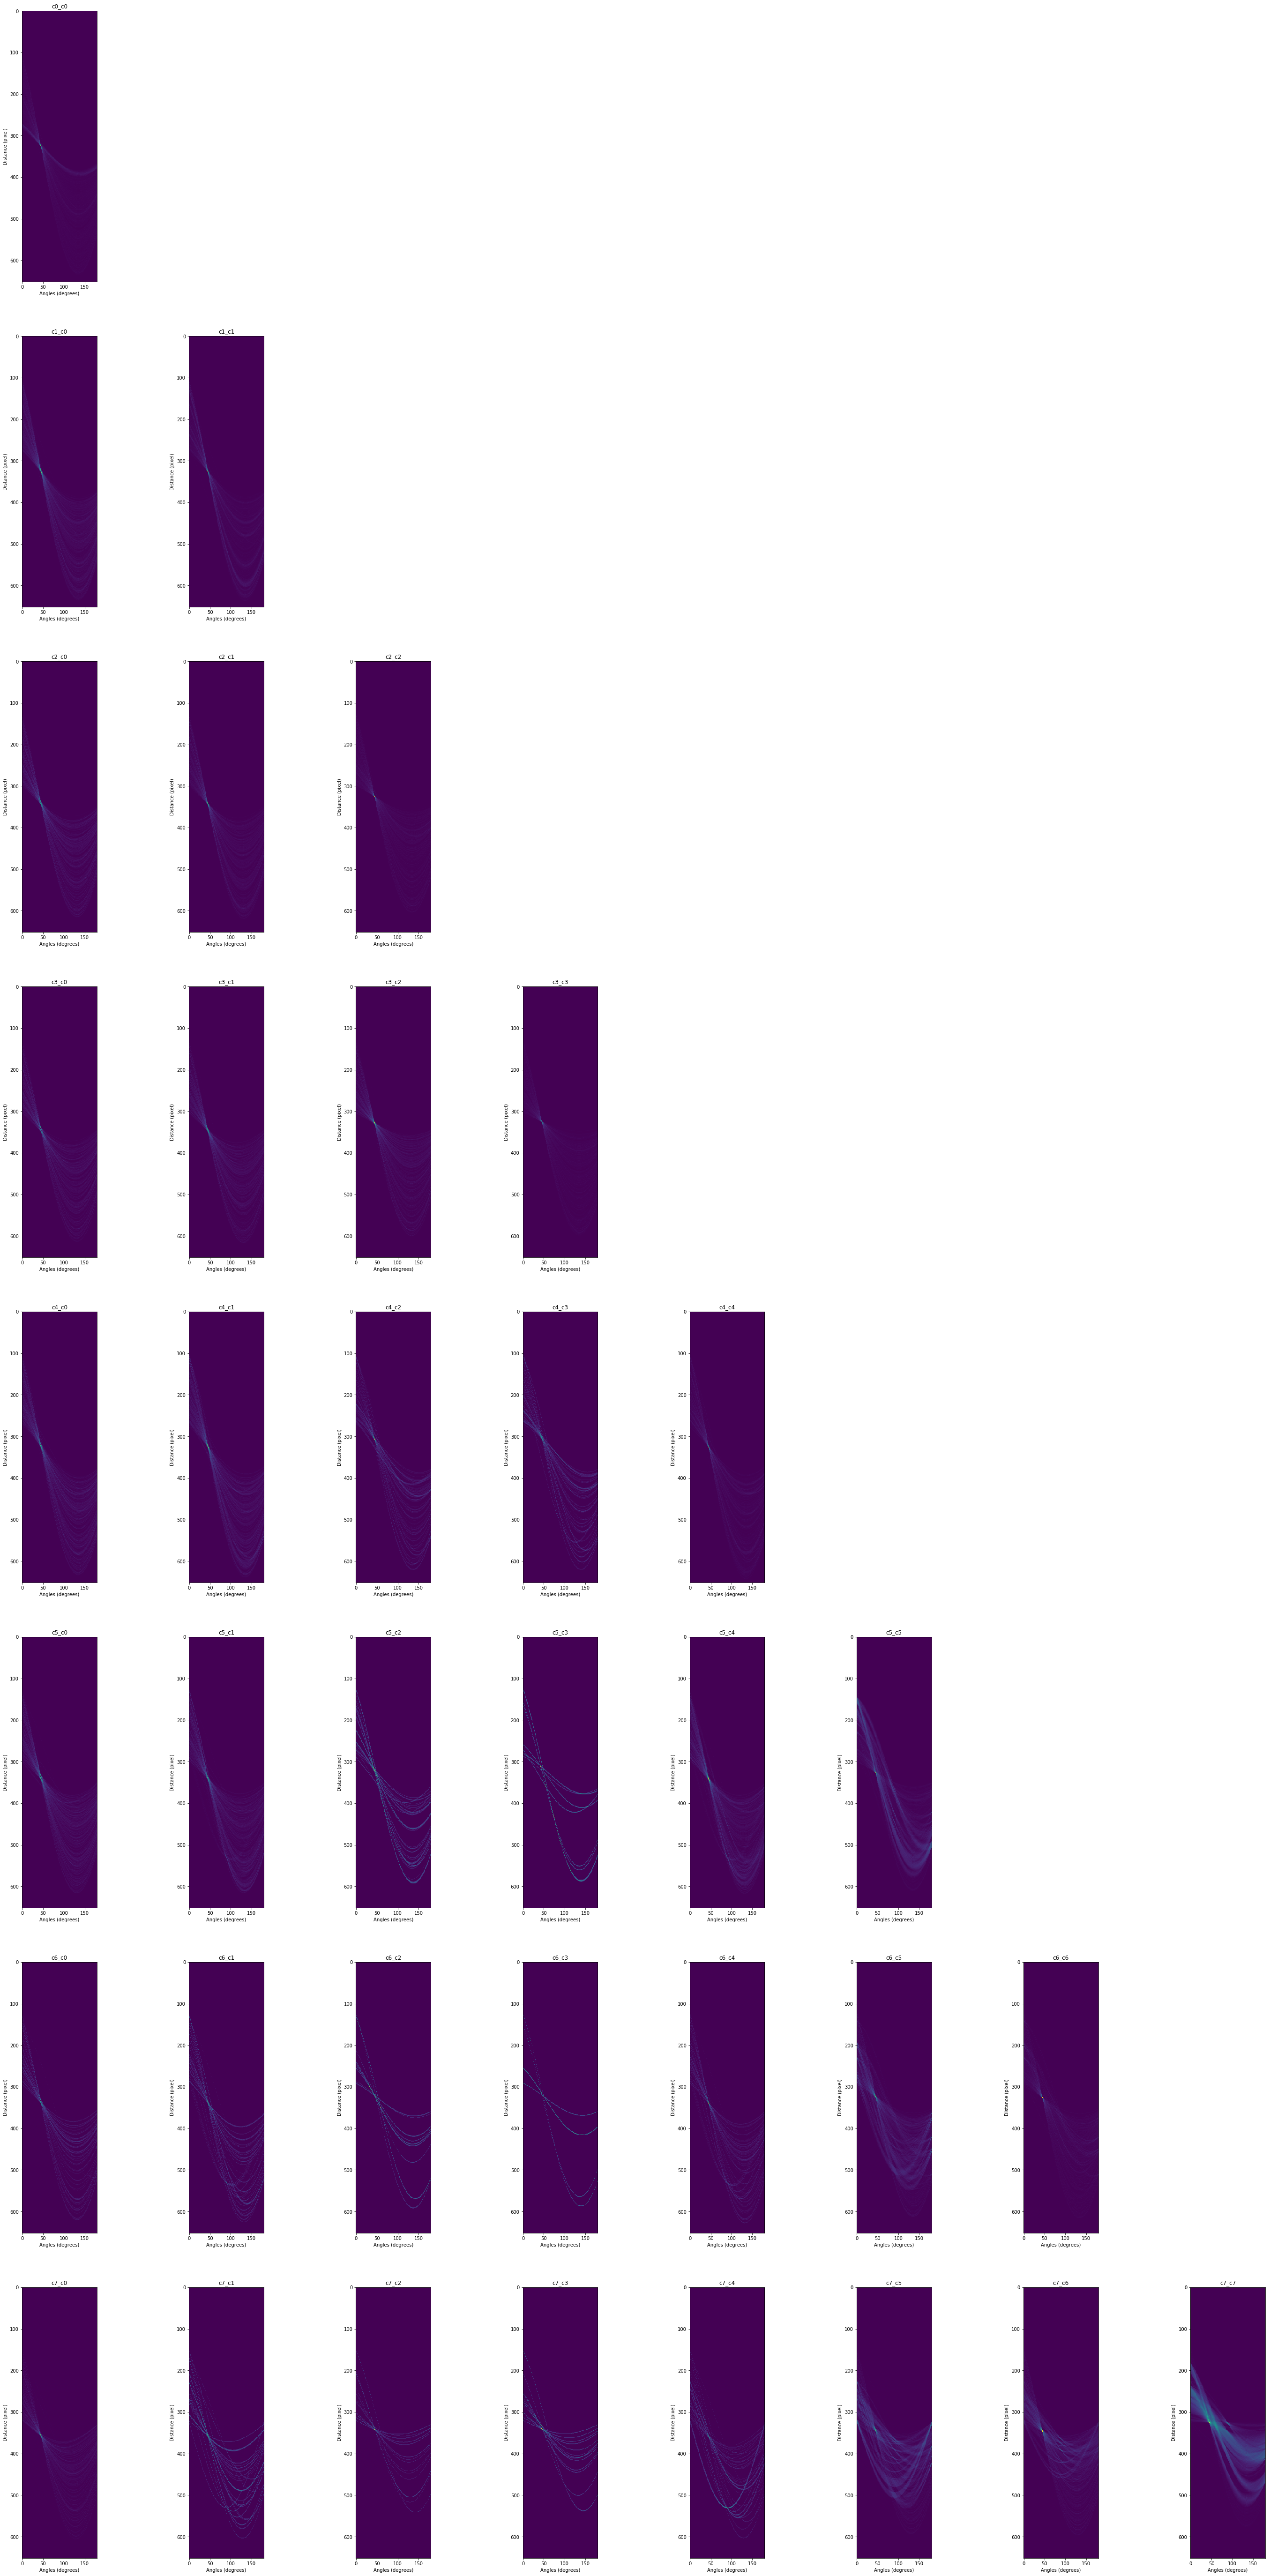

In [37]:
cam_num = 8
plt.figure(figsize=(50,100))
for i in range(cam_num):
    for j in range(i+1):
        h, theta, d = st.hough_line(hough.accumulators[i][j])
        plt.subplot(cam_num, cam_num, i * cam_num + j + 1)
        plt.imshow(h)
        plt.title('c%d_c%d' % (i, j))
        plt.xlabel('Angles (degrees)')
        plt.ylabel('Distance (pixel)')
plt.show()

In [56]:
 def plot_dist(c1, c2):
    c1r, c2r = (c1, c2) if c1 > c2 else (c2, c1)
    plt.figure(figsize=(15, 10))
    # plot hough
    h, theta, d = st.hough_line(hough.accumulators[c1r][c2r])
    h_45 = []
    for r in range(len(h)):
        for j in range(h[r][45]):
            h_45.append(- d[r] * hough.grid_len * np.sqrt(2))
    sns.distplot(h_45, label='hough')
    # plot delta
    sns.distplot(hough.deltas[c1r][c2r], label='delta')
    plt.legend()

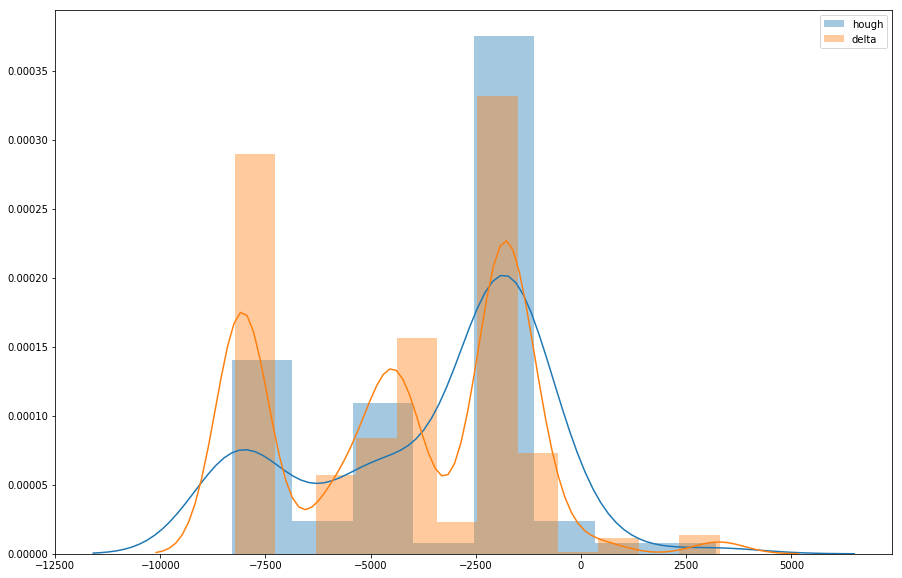

In [57]:
plot_dist(7,4)

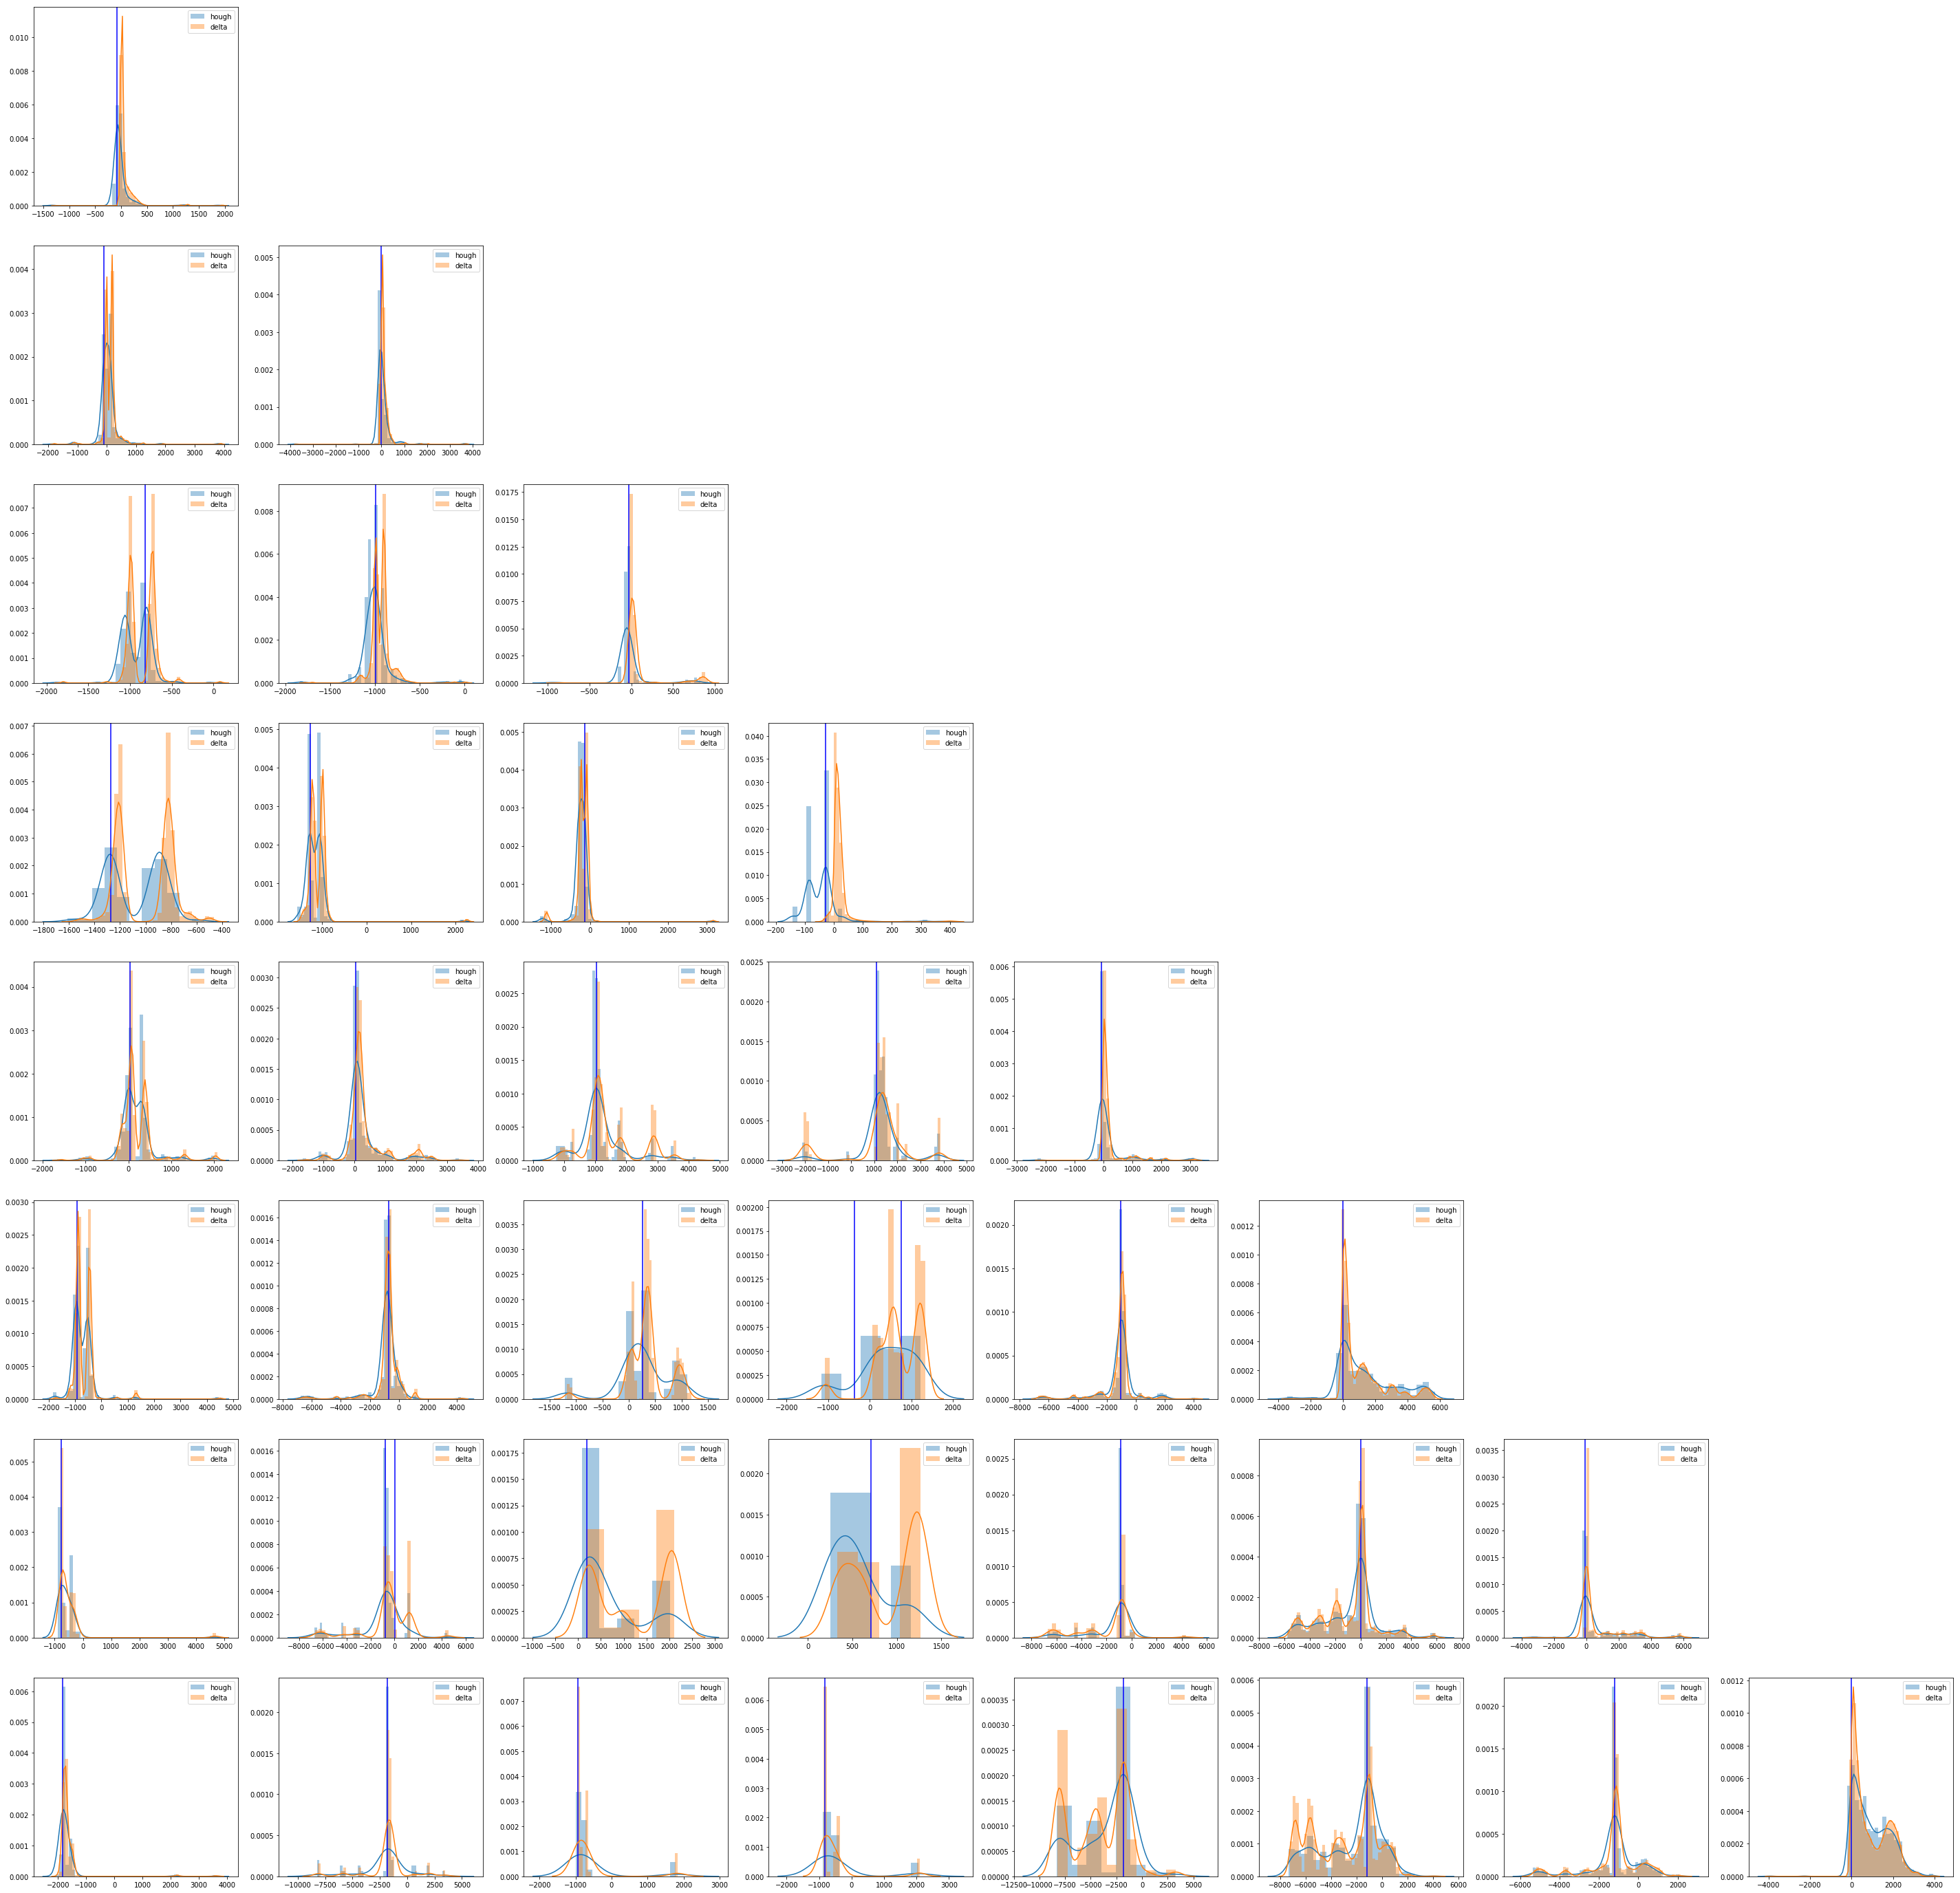

In [58]:
cam_num = 8
plt.figure(figsize=(50,50))
for i in range(cam_num):
    for j in range(i+1):
        plt.subplot(cam_num, cam_num, i * cam_num + j + 1)
        h, theta, d = st.hough_line(hough.accumulators[i][j])
        # plot hough
        h_45 = []
        for r in range(len(h)):
            for _ in range(h[r][45]):
                h_45.append(- d[r] * hough.grid_len * np.sqrt(2))
        sns.distplot(h_45, label='hough')
        # plot hough peak
        peaks = list(zip(*st.hough_line_peaks(h, theta, d, num_peaks=10)))
        filted_peaks = list(filter(lambda peak: np.abs(peak[1] + np.pi / 4) < 0.05, peaks))
        for peak in list(map(lambda peak: -peak[2] * hough.grid_len * np.sqrt(2), filted_peaks)):
            plt.axvline(peak, color='b')
        # plot delta
        sns.distplot(hough.deltas[i][j], label='delta')
        plt.legend()
plt.savefig('vis/duke.png')
plt.show()